In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, sampler
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Only run once, don't rerun in same runtime
%cd drive/My\ Drive/DeepAdDetection/
!pwd


/content/drive/My Drive/DeepAdDetection
/content/drive/My Drive/DeepAdDetection


In [3]:
device = torch.device("cuda" if torch.cuda.is_available()
                               else "cpu")
print("We are using: ", device)

We are using:  cuda


In [4]:
img_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

data = datasets.ImageFolder(root ="./data-new",  transform = img_transforms)


data_indices = list(range(len(data)))[:16696] # class imbalance bc 8348 ads and 13597 non ads, so we resize to 8348 ads and 8348 nonads
# ad, non_ad = data_indices[:8348], data_indices[8348:]
# data_indices = ad[:5000] + non_ad[:5000] 

print(len(data_indices))
np.random.shuffle(data_indices)
# 70/15/15 split for train/val/test
val_split_index = len(data_indices) - int(np.floor(0.30 * len(data_indices)))
test_split_index = len(data_indices) - int(np.floor(0.15 * len(data_indices)))

print("val split index: ", val_split_index)
print("test_split_index: ", test_split_index)

train_idx = data_indices[: val_split_index]
val_idx = data_indices[val_split_index: test_split_index]
test_idx = data_indices[test_split_index:]

print("len train: ", len(train_idx))
print("len val: ", len(val_idx))
print("len test: ", len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=64, sampler=test_sampler, num_workers=4)

data.class_to_idx.items()


16696
val split index:  11688
test_split_index:  14192
len train:  11688
len val:  2504
len test:  2504


dict_items([('ad', 0), ('not-ad', 1)])

In [1]:
# model = models.resnet34(pretrained=True) # resnet34
model = models.resnet101(pretrained=True) # resnet 101

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)




NameError: ignored

In [0]:
# # Squeezenet (no linear layer, so we replace last conv layer w right number of classes)
# # change the last conv2d layer
# model = models.squeezenet1_0(pretrained=True) 
# model.classifier._modules["1"] = nn.Conv2d(512, 2, kernel_size=(1, 1))
# # change the internal num_classes variable rather than redefining the forward pass
# model.num_classes = 2

In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [0]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [10]:
print("Begin training.")

for e in tqdm(range(15)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        print(i, len(train_loader), train_epoch_loss, train_epoch_acc)
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            j += 1
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            # y_val_pred = model(X_val_batch).squeeze()
            # y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
            print(j, len(val_loader), val_epoch_loss, val_epoch_acc)

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


0 183 0.7182726860046387 48.0
1 183 2.0629944801330566 106.0
2 183 4.671241044998169 162.0
3 183 6.398491263389587 221.0
4 183 7.226246237754822 285.0
5 183 8.56690239906311 343.0
6 183 9.759069681167603 396.0
7 183 10.633770644664764 466.0
8 183 11.5831817984581 533.0
9 183 12.591134369373322 594.0
10 183 13.096674680709839 674.0
11 183 14.194198608398438 733.0
12 183 15.029725432395935 805.0
13 183 15.729450821876526 867.0
14 183 16.37988954782486 944.0
15 183 17.145065486431122 1006.0
16 183 17.78260439634323 1087.0
17 183 18.706464111804962 1151.0
18 183 19.26707512140274 1228.0
19 183 19.739579170942307 1309.0
20 183 20.395895391702652 1382.0
21 183 20.972063094377518 1451.0
22 183 21.61438325047493 1520.0
23 183 22.160976380109787 1592.0
24 183 22.84856018424034 1661.0
25 183 23.5735082924366 1728.0
26 183 24.25002059340477 1795.0
27 183 24.92048290371895 1859.0
28 183 25.499446898698807 1931.0
29 183 25.871193379163742 2014.0
30 183 26.500586718320847 2080.0
31 183 26.9711664617

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

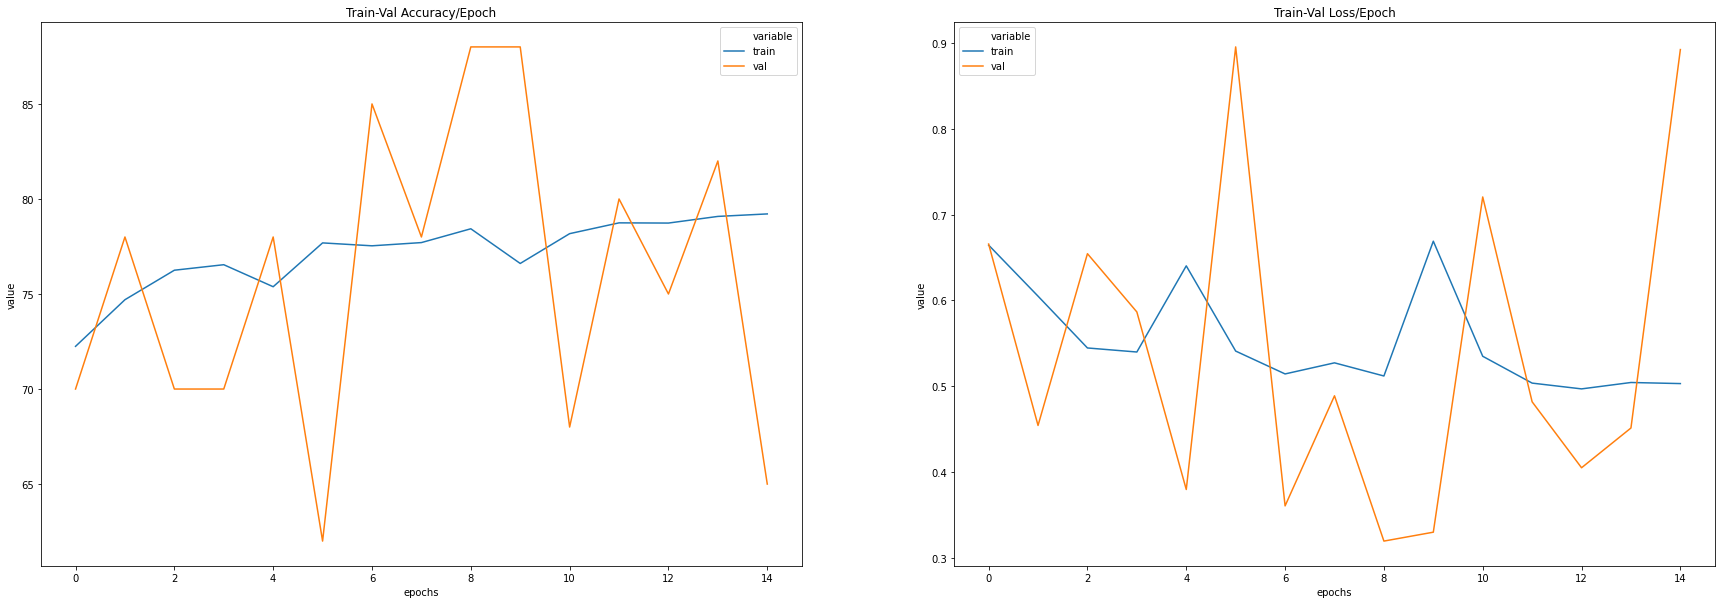

In [11]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [12]:
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=1, sampler=test_sampler)
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1275
           1       0.73      0.86      0.79      1229

    accuracy                           0.78      2504
   macro avg       0.79      0.78      0.78      2504
weighted avg       0.79      0.78      0.78      2504

[[ 886  389]
 [ 168 1061]]


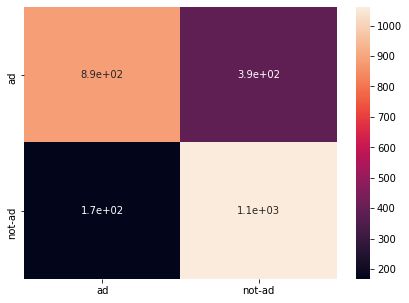

In [14]:
idx2class = {v: k for k, v in data.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)